# sigma54-RNAP-Cy3 binding to 598P2993

Fig. 3D in [RNA polymerase approaches its promoter without
long-range sliding along DNA](https://www.pnas.org/content/pnas/110/24/9740.full.pdf)

## Setup

In [1]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path

import pyro
import pyro.distributions as dist
from pyro.ops.stats import pi, resample
from pyro.infer import Predictive

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from tapqir.models import Cosmos, HMM
from tapqir.imscroll.glimpse_reader import GlimpseDataset
from tapqir.utils.imscroll import time_to_first_binding

from tapqir.utils.mle_analysis import train, ttfb_model, ttfb_guide

## View Data

In [2]:
# load glimpse
path_data = Path("/shared/centaur/paper/sigma54RNAPCy3-598P2993")
# glimpse = GlimpseDataset(path_data)

# load model & parameters
model = Cosmos(verbose=False)
model.load(path_data, data_only=False)

### AOIs

In [3]:
glimpse.aoiinfo["test"]

,frame,ave,x,y,pixnum
aoi,,,,,
1,28.0,5.0,314.452808,100.175625,8.0
2,28.0,5.0,314.725694,84.978373,8.0
3,28.0,5.0,328.625477,83.399878,8.0
4,28.0,5.0,311.078359,51.571321,8.0
5,28.0,5.0,273.370180,52.027392,8.0
...,...,...,...,...,...
118,28.0,5.0,448.612006,419.915098,10.0
119,28.0,3.0,215.437014,312.936510,9.0
120,28.0,3.0,165.648914,427.485576,9.0


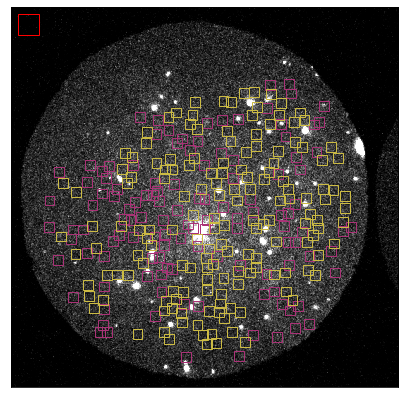

In [4]:
plt.figure(figsize=(7, 7))

frame = 2078 - 47
# plot selected area of the image
plt.imshow(glimpse[frame][:, :550], cmap="gray",
           vmin=model.data.vmin, vmax=model.data.vmax)

for aoi in glimpse.aoiinfo["test"].index:
    # on-target area
    y_pos = round(glimpse.aoiinfo["test"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5
    x_pos = round(glimpse.aoiinfo["test"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#AA3377", lw=1, facecolor="none"))

for aoi in glimpse.aoiinfo["control"].index:
    # off-target area
    y_pos = round(glimpse.aoiinfo["control"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5
    x_pos = round(glimpse.aoiinfo["control"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#CCBB44", lw=1, facecolor="none"))
    

plt.gca().add_patch(Rectangle((10, 10), 30, 30,
                    edgecolor="r", lw=1, facecolor="none"))
    
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### Driftlist

In [5]:
glimpse.cumdrift

,dx,dy
frame,,
47,0.000000,0.000000
48,0.000242,0.000391
49,0.000484,0.000783
50,0.000727,0.001176
51,0.000973,0.001574
...,...,...
3897,1.055898,4.725019
3898,1.056138,4.725881
3899,1.056379,4.726741


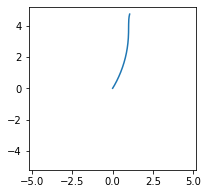

In [6]:
plt.figure(figsize=(3,3))
plt.plot(glimpse.cumdrift["dx"], glimpse.cumdrift["dy"])
lim = glimpse.cumdrift.abs().max().max() * 1.1
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

### Offset

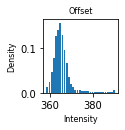

In [3]:
plt.figure(figsize=(1.35,1.35))
plt.bar(model.data.offset.samples, model.data.offset.weights)
plt.title("Offset", fontsize=8)
plt.ylabel("Density", fontsize=8)
plt.xlabel("Intensity", fontsize=8)
plt.show()

### Global parameters

In [4]:
model.statistics

,Mean,95% LL,95% UL
gain,16.672916164694346,16.651433,16.693723
proximity,0.37795470728575176,0.373296,0.382067
lamda,0.0711926391865767,0.069278,0.072963
SNR,4.2180127442578135,NaN,NaN
MCC,0.9170187151550024,NaN,NaN
Recall,0.8668801782357446,NaN,NaN
Precision,0.9750195771339076,NaN,NaN
TN,455628,NaN,NaN
FP,319,NaN,NaN
FN,1912,NaN,NaN


## Figures

### Figure 4

In [3]:
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)

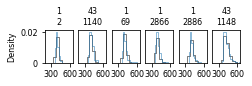

In [4]:
aois = [1, 43, 1, 1, 1, 43]
frames = [2, 1140, 69, 2866, 2886, 1148]

plt.figure(figsize=(3.5, 0.6))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.title(f"{n}\n{f}", fontsize=8)
    plt.hist(
        model.data.ontarget.images[n, f].flatten().numpy(),
        range=(200, model.data.vmax+150),
        density=True, bins=10, histtype="step", lw=0.5, color="k")
    model.n = torch.tensor([n])
    samples = predictive()
    img_sample = model.data.offset.samples[samples["d/offset"][0, 0, f]] + samples["d/data"][0, 0, f]
    plt.hist(
        img_sample.flatten().numpy(),
        range=(200, model.data.vmax+150),
        density=True, bins=20, histtype="step", lw=0.5, color="C0")
    plt.xlim(200, model.data.vmax+150)
    plt.xticks([300, 600], fontsize=8)
    if i == 0:
        plt.yticks(fontsize=8)
        plt.ylabel("Density", fontsize=8)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    else:
        plt.yticks([])

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/598P2993-hist.svg")

plt.show()

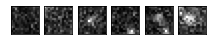

In [5]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(model.data.ontarget.images[n, f].numpy(), vmin=model.data.vmin, vmax=model.data.vmax+50, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/598P2993-data.png", dpi=600)

plt.show()

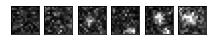

In [6]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    model.n = torch.tensor([n])
    samples = predictive()
    img_sample = model.data.offset.samples[samples["d/offset"][0, 0, f]] + samples["d/data"][0, 0, f]
    plt.imshow(img_sample.numpy(), vmin=model.data.vmin, vmax=model.data.vmax+50, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/598P2993-sample.png", dpi=600)

plt.show()

### Extended Data Figure 4

#### Rastegram

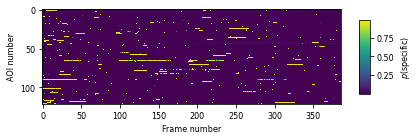

In [5]:
# on-target
ttfb = time_to_first_binding(model.params["z_map"])
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.params["p(specific)"][:, ::10], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

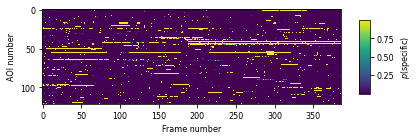

In [6]:
# off-target
plt.figure(figsize=(6, 2))
plt.imshow(1 - (1 - model.params["d/j_probs"][:, :, ::10]).prod(0), aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

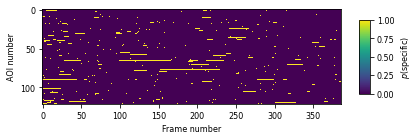

In [7]:
# spotpicker
ttfb = time_to_first_binding(model.data.ontarget.labels["z"])
# sort ttfb
sdx = np.flip(np.argsort(ttfb))


plt.figure(figsize=(6, 2))
plt.imshow(model.data.ontarget.labels["z"][:, ::10], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

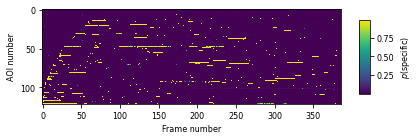

In [8]:
# sorted on-target
ttfb = time_to_first_binding(model.params["z_map"])
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.params["p(specific)"][sdx][:, ::10], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure4/598P2993-rastegram.png", dpi=900)
plt.show()

#### Tapqir fit

In [9]:
control = None
Tmax = model.data.ontarget.F

z = dist.Bernoulli(model.params["p(specific)"]).sample((1000,))
data = time_to_first_binding(z)

In [10]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data.cuda(), control=control, Tmax=Tmax, jit=False
)

In [11]:
results = pd.DataFrame(columns=["Mean", "95% LL", "95% UL"])

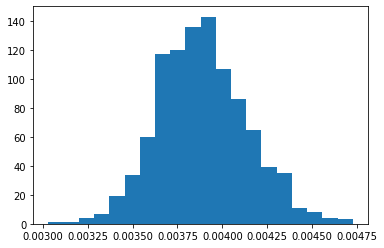

In [12]:
plt.hist(pyro.param("ka").data.squeeze().cpu().numpy(), bins=20)
plt.show()

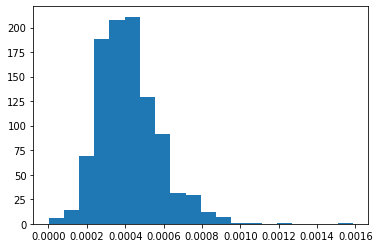

In [13]:
plt.hist(pyro.param("kns").data.squeeze().cpu().numpy(), bins=20)
plt.show()

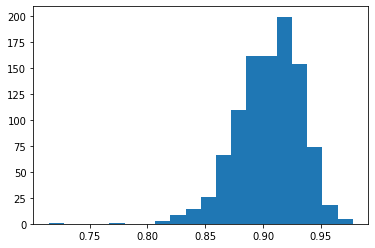

In [14]:
plt.hist(pyro.param("Af").data.squeeze().cpu().numpy(), bins=20)
plt.show()

In [15]:
results.loc["ka", "Mean"] = pyro.param("ka").mean().item()
ll, ul = pi(pyro.param("ka").data.squeeze(), 0.95, dim=0)
results.loc["ka", "95% LL"], results.loc["ka", "95% UL"] = ll.item(), ul.item()

In [16]:
results.loc["kns", "Mean"] = pyro.param("kns").mean().item()
ll, ul = pi(pyro.param("kns").data.squeeze(), 0.95, dim=0)
results.loc["kns", "95% LL"], results.loc["kns", "95% UL"] = ll.item(), ul.item()

In [17]:
results.loc["Af", "Mean"] = pyro.param("Af").mean().item()
ll, ul = pi(pyro.param("kns").data.squeeze(), 0.95, dim=0)
results.loc["Af", "95% LL"], results.loc["Af", "95% UL"] = ll.item(), ul.item()

In [18]:
results

,Mean,95% LL,95% UL
ka,0.003891,0.003435,0.004389
kns,0.000421,0.000167,0.000784
Af,0.905081,0.000167,0.000784


In [19]:
torch.set_default_tensor_type(torch.FloatTensor)

nz = (data == 0).sum(1, keepdim=True)
n = (data == Tmax).sum(1, keepdim=True)
N = data.shape[1]

In [20]:
fraction_bound = (data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

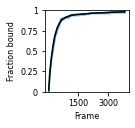

In [21]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (results.loc["Af", "Mean"]*(1 - torch.exp(-(results.loc["ka", "Mean"]+results.loc["kns", "Mean"]) * torch.arange(Tmax))) +
    (1 - results.loc["Af", "Mean"])*(1 - torch.exp(-results.loc["kns", "Mean"] * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.xticks([1500, 3000], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure4/598P2993-tapqir.svg")
plt.show()

#### Spotpicker fit

In [22]:
Tmax = model.data.ontarget.F

spotpicker_data = time_to_first_binding(model.data.ontarget.labels["z"])
spotpicker_data = torch.tensor(spotpicker_data, dtype=torch.float)
spotpicker_control = time_to_first_binding(model.data.offtarget.labels["z"])
spotpicker_control = torch.tensor(spotpicker_control, dtype=torch.float)

bootstrap_data = torch.stack(
    [resample(spotpicker_data, num_samples=len(spotpicker_data), replacement=True) for _ in range(1000)],
    dim=0
)
bootstrap_control = torch.stack(
    [resample(spotpicker_control, num_samples=len(spotpicker_control), replacement=True) for _ in range(1000)],
    dim=0
)

In [23]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=bootstrap_data.cuda(), control=bootstrap_control.cuda(), Tmax=Tmax, jit=False
)

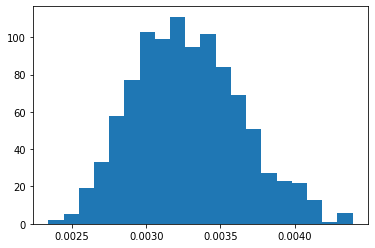

In [24]:
plt.hist(pyro.param("ka").data.squeeze().cpu().numpy(), bins=20)
plt.show()

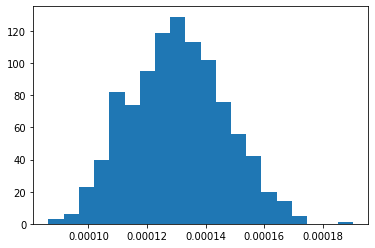

In [25]:
plt.hist(pyro.param("kns").data.squeeze().cpu().numpy(), bins=20)
plt.show()

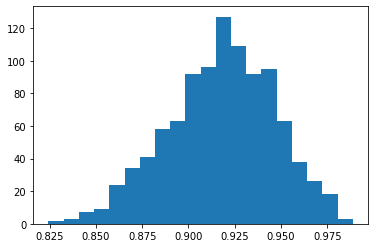

In [26]:
plt.hist(pyro.param("Af").data.squeeze().cpu().numpy(), bins=20)
plt.show()

In [27]:
results.loc["ka_sp", "Mean"] = pyro.param("ka").mean().item()
ll, ul = pi(pyro.param("ka").data.squeeze(), 0.95, dim=0)
results.loc["ka_sp", "95% LL"], results.loc["ka_sp", "95% UL"] = ll.item(), ul.item()

In [28]:
results.loc["kns_sp", "Mean"] = pyro.param("kns").mean().item()
ll, ul = pi(pyro.param("kns").data.squeeze(), 0.95, dim=0)
results.loc["kns_sp", "95% LL"], results.loc["kns_sp", "95% UL"] = ll.item(), ul.item()

In [29]:
results.loc["Af_sp", "Mean"] = pyro.param("Af").mean().item()
ll, ul = pi(pyro.param("kns").data.squeeze(), 0.95, dim=0)
results.loc["Af_sp", "95% LL"], results.loc["Af_sp", "95% UL"] = ll.item(), ul.item()

In [30]:
results

,Mean,95% LL,95% UL
ka,0.003891,0.003435,0.004389
kns,0.000421,0.000167,0.000784
Af,0.905081,0.000167,0.000784
ka_sp,0.003279,0.002643,0.004049
kns_sp,0.00013,0.000101,0.000163
Af_sp,0.917658,0.000101,0.000163


In [31]:
torch.set_default_tensor_type(torch.FloatTensor)

nz = (bootstrap_data == 0).sum(1, keepdim=True)
n = (bootstrap_data == Tmax).sum(1, keepdim=True)
N = bootstrap_data.shape[1]

nzc = (bootstrap_control == 0).sum(1, keepdim=True)
nc = (bootstrap_control == Tmax).sum(1, keepdim=True)
Nc = bootstrap_control.shape[1]

In [32]:
fraction_bound = (bootstrap_data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

fraction_boundc = (bootstrap_control.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fbc_ll, fbc_ul = pi(fraction_boundc, 0.68, dim=0)

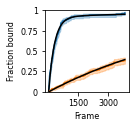

In [33]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (results.loc["Af_sp", "Mean"]*(1 - torch.exp(-(results.loc["ka_sp", "Mean"]+results.loc["kns_sp", "Mean"]) * torch.arange(Tmax))) +
    (1 - results.loc["Af_sp", "Mean"])*(1 - torch.exp(-results.loc["kns_sp", "Mean"] * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.fill_between(
    torch.arange(Tmax),
    fbc_ll, fbc_ul,
    alpha=0.3, color="C1"
)
plt.plot(torch.arange(Tmax), fraction_boundc.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nzc / Nc +
    (1 - nzc / Nc) *
    (1 - torch.exp(-results.loc["kns_sp", "Mean"] * torch.arange(Tmax)))).mean(0),
    color="k"
)

plt.xticks([1500, 3000], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure4/598P2993-spotpicker.svg")
plt.show()